In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

## Loading data generated in notebooks 1 and 2
Both datasets contain 1000 spectra that have at least 5 matching spectra in the library and 1000 spectra that have no match in the library.

In [2]:
#loading training set
import pickle

#if this file already exists these data files are no longer needed to load
outfile_check = os.path.join(path_data, 'nn_prep_old_and_unique_found_matches_s2v.pickle')
print(outfile_check)
if not os.path.exists(outfile_check):
    outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v.pickle')
    print(outfile)
    if os.path.exists(outfile):
        with open(outfile, 'rb') as inf:
            old_and_unique_found_matches_s2v = pickle.load(inf)
    else:
        print('error')

    outfile = os.path.join(path_data, 'old_and_unique_documents_library_s2v.pickle')
    print(outfile)
    if os.path.exists(outfile):
        with open(outfile, 'rb') as inf:
            old_and_unique_documents_library_s2v = pickle.load(inf)
    else:
        print('error')

    outfile = os.path.join(path_data, 'old_and_unique_documents_query_s2v.pickle')
    print(outfile)
    if os.path.exists(outfile):
        with open(outfile, 'rb') as inf:
            old_and_unique_documents_query_s2v = pickle.load(inf)
    else:
        print('error')

C:\Users\joris\Documents\eScience_data\data\nn_prep_old_and_unique_found_matches_s2v.pickle


In [3]:
#loading test set
outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v = pickle.load(inf)
else:
    print('error')

outfile = os.path.join(path_data, 'new_and_unique2_documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_documents_library_s2v = pickle.load(inf)
else:
    print('error')

outfile = os.path.join(path_data, 'new_and_unique2_documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_documents_query_s2v = pickle.load(inf)
else:
    print('error')

C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\new_and_unique2_documents_library_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\new_and_unique2_documents_query_s2v.pickle


In [4]:
from rdkit import Chem, DataStructs

def find_info_matches(matches, documents_library, documents_query,
                      add_label = True, add_tanimoto_sim = True, add_cols = False,
                      add_num_matches_transform = True, add_mass_transform = True,
                      add_mass_similarity = True):
    '''
    To each df in matches, add more info like tanimoto scores vs query etc.
    
    A matching inchikey gets label 1 and non-matching 0.

    matches: list of pandas DataFrames, library matching result of query on library
    documents_library: list of SpectrumDocuments, spectra in library
    documents_query: list of SpectrumDocuments, spectra in query set.
        Indices should correspond to indices of matches.
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    add_label: bool, add a label for inchikey match or not
    add_tanimoto_sim: bool, add tanimoto similarity or not
    add_cols: bool/list of str, add other info present in metadata such as parent_mass, adduct
        default: False
    add_num_matches_transform: bool, transform cosine and mod_cosine matches to a number 0-1.
        both matches are transformed to between 0-1 by doing 1-0.93^num_matches
    add_mass_transform: bool, add transform of the parent masses to a fraction of the maximal parent mass
    add_mass_similarity: bool, add similarity of parent mass to the query as a scaled number from 0-1
        where The similarity in dalton is calculated and transformed into a value 0 - 1 by doing
        1 - base_num^diff_in_dalton
    
    Output
    matches_with_info: list of pandas DataFrames, library matching result of query
        on library with matching labels
    '''
    matches_with_info = []
    if add_mass_transform:
        all_q_masses = [documents_query[query_id]._obj.get("parent_mass") \
                            for query_id in range(len(documents_query))]
        all_l_masses = [documents_library[lib_id]._obj.get("parent_mass") \
                            for lib_id in range(len(documents_library))]
        max_parent_mass = max(all_q_masses + all_l_masses)
        print('Max parent mass:', max_parent_mass)

    for query_id in range(len(documents_query)):
        match = matches[query_id].copy()
        if add_label:
            query_inchi = documents_query[query_id]._obj.get("inchikey")[:14]
            match = find_inchikey_match(match, documents_library, query_inchi)
        if add_cols:
            match = find_basic_info(match, documents_library, add_cols)
        if add_tanimoto_sim:
            query_smiles = documents_query[query_id]._obj.get("smiles")
            match = find_tanimoto_sim(match, documents_library, query_smiles)
        if add_num_matches_transform:
            match = transform_num_matches(match)
        if add_mass_transform:
            #add parent_mass if its not there already
            match = find_basic_info(match, documents_library, add_cols = ['parent_mass'])
            match['parent_mass'] = [cur_pm/max_parent_mass for cur_pm in match['parent_mass']]
        if add_mass_similarity:
            match.drop(['mass_match'], axis=1, inplace=True)
            q_mass = documents_query[query_id]._obj.get("parent_mass")
            match = find_mass_similarity(match, documents_library, q_mass, base_num = 0.8)
        
        matches_with_info.append(match)
    return matches_with_info

def find_inchikey_match(matches, documents_library, query_inchi):
    '''To each match in the matches df, add label for matching inchikey (1) or non-matching (0)

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_inchi: str, first 14 symbols of query inchikey
    df: pandas DataFrame, library matching result of query on library with matching labels
    '''
    matches_with_labels = []
    df = matches.copy()
    library_ids = df.index.values
    labels = []
    for lib_id in library_ids:
        lib_inchi = documents_library[lib_id]._obj.get("inchikey")[:14]
        lab = 0
        if query_inchi == lib_inchi:
            lab = 1
        labels.append(lab)
    df['label'] = labels
    return df

def find_mass_matches(matches, documents_library, query_mass, bins = [2, 5], calc_change = False):
    '''
    To each match in matches df, add the mass change of query to match in bins or a percentage change

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_mass: float, parent mass of query
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    df: pandas DataFrame, library matching result of 1 query on library with mass matches
    '''
    range_bins = range(len(bins)) #calc once
    df = matches.copy()
    library_ids = df.index.values
    masses = [[] for _ in range_bins] #initialise
    mass_changes = []
    for lib_id in library_ids:
        lib_mass = documents_library[lib_id]._obj.get("parent_mass")
        if calc_change: #calculate a percentage change in parent mass instead of discrete bins
            perc_change = abs(lib_mass - query_mass) / query_mass * 100
            mass_changes.append(perc_change)
        else:
            for bin_i in range_bins:
                cutoff = bins[bin_i]
                lab = 0
                if abs(query_mass - lib_mass) < cutoff:
                    lab = 1
                masses[bin_i].append(lab)
    #add to df
    if calc_change:
        df['perc_mass_change'] = mass_changes
    else:
        for bin_i in range_bins:
            df['mass_match_' + str(bins[bin_i])] = masses[bin_i]
    return df

def find_basic_info(matches, documents_library, add_cols = ['parent_mass']):
    '''
    To each match in matches df, add the info from add_cols entries

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with added info
    '''
    df = matches.copy()
    library_ids = df.index.values
    if add_cols:
        for col in add_cols:
            col_data = []
            for lib_id in library_ids:
                lib_data = documents_library[lib_id]._obj.get(col)
                col_data.append(lib_data)
            df[col] = col_data
    return df

def find_tanimoto_sim(matches, documents_library, query_smiles):
    '''To each match in matches df, add the tanimoto similarity between query and match

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with tanimoto similarities
    '''
    df = matches.copy()
    sims = []
    library_ids = df.index.values
    
    if not query_smiles or query_smiles == "None": # check that query smiles exist
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    ms_q = Chem.MolFromSmiles(query_smiles)
    if not ms_q: #in case something is wrong with smiles
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    
    fp_q = Chem.RDKFingerprint(ms_q)
    for lib_id in library_ids:
        smiles_lib = documents_library[lib_id]._obj.get("smiles")
        if smiles_lib and smiles_lib != "None":
            ms_lib = Chem.MolFromSmiles(smiles_lib)
            if ms_lib:
                fp_lib = Chem.RDKFingerprint(ms_lib)
                score = DataStructs.FingerprintSimilarity(fp_q, fp_lib)
            else: #in case something is wrong with smiles
                score = 0
        else: #in case it doesnt have smiles
            score = 0
        sims.append(score)
    df['similarity'] = sims
    return df

def transform_num_matches(input_df, exp = 0.93):
    '''Transform the cosine_matches and mod_cosine_matches to between 0-1
    
    input_df: pandas DataFrame, spec2vec matches for one query
    exp: int, the base for the exponential, default: 0.93
    
    Both matches are transformed to between 0-1 by doing 1-0.93^num_matches
    '''
    df = input_df.copy() #otherwise it edits the df outside the function
    df['cosine_matches'] = [(1-0.93**i) for i in df['cosine_matches']]
    df['mod_cosine_matches'] = [(1-0.93**i) for i in df['mod_cosine_matches']]
    return df

def find_mass_similarity(matches, documents_library, query_mass, base_num = 0.8):
    '''
    To each match in matches df, add a scaled value for how similar the parent_mass is to the query

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_mass: float, parent mass of query
    base_num: float, the base for the exponent
    df: pandas DataFrame, library matching result of 1 query on library with mass sims
    
    The similarity in dalton is calculated and transformed into a value 0 - 1 by doing
    1 - base_num^diff_in_dalton
    '''
    df = matches.copy()
    library_ids = df.index.values
    scaled_mass_sims = []
    for lib_id in library_ids:
        lib_mass = documents_library[lib_id]._obj.get("parent_mass")
        mass_diff = abs(lib_mass - query_mass)
        scaled_mass_sim = base_num ** mass_diff
        scaled_mass_sims.append(scaled_mass_sim)

    #add to df
    df['mass_sim'] = scaled_mass_sims
    return df

In [5]:
outfile = os.path.join(path_data, 'nn_prep_old_and_unique_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_old_and_unique_found_matches_s2v = pickle.load(inf)
else:
    nn_prep_old_and_unique_found_matches_s2v = find_info_matches(old_and_unique_found_matches_s2v, old_and_unique_documents_library_s2v, old_and_unique_documents_query_s2v)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_old_and_unique_found_matches_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_old_and_unique_found_matches_s2v.pickle


In [6]:
outfile = os.path.join(path_data, 'nn_prep_new_and_unique2_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_new_and_unique2_found_matches_s2v = pickle.load(inf)
else:
    nn_prep_new_and_unique2_found_matches_s2v = find_info_matches(new_and_unique2_found_matches_s2v, new_and_unique2_documents_library_s2v, new_and_unique2_documents_query_s2v)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_new_and_unique2_found_matches_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_new_and_unique2_found_matches_s2v.pickle


In [7]:
nn_prep_new_and_unique2_found_matches_s2v[0].sort_values('s2v_score', ascending = False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim
45439,0.792853,0.195643,0.792853,0.195643,0.814472,0,0.947368,0.061835,1.000000
32666,0.000000,0.000000,0.000000,0.000000,0.606157,0,1.000000,0.061685,0.637861
36488,0.122287,0.070000,0.122721,0.135100,0.570656,0,1.000000,0.061535,0.406776
46660,0.010289,0.070000,0.010289,0.070000,0.559132,1,1.000000,0.061835,1.000000
30026,0.000017,0.070000,0.011877,0.135100,0.550621,0,1.000000,0.061685,0.637861
...,...,...,...,...,...,...,...,...,...
80489,0.000000,0.000000,0.000000,0.000000,-0.034227,0,0.137269,0.061886,0.857873
15872,0.000000,0.000000,0.000000,0.000000,-0.034334,0,0.135556,0.061886,0.857873
51551,0.000000,0.000000,0.000000,0.000000,-0.042802,0,0.483731,0.061898,0.828708
14058,0.000000,0.000000,0.012161,0.070000,-0.067819,0,0.220232,0.061883,0.866724


## Training for tanimoto score

In [8]:
#append all the queries and remove the label column
nn_tanimoto_old_and_unique_found_matches_s2v = nn_prep_old_and_unique_found_matches_s2v[0]\
    .append(nn_prep_old_and_unique_found_matches_s2v[1:])\
    .drop(['label'], axis = 1)


In [9]:
nn_tanimoto_new_and_unique2_found_matches_s2v = nn_prep_new_and_unique2_found_matches_s2v[0]\
    .append(nn_prep_new_and_unique2_found_matches_s2v[1:])\
    .drop(['label'], axis = 1)

In [10]:
#top20

def make_s2v_selection(matches, topn):
    '''Return one df with topn matches (based on s2v_score) for each query
    
    matches: list of pandas DataFrames, library matching result with matching labels
    topn: int, number of top hits to select, sorted on s2v_score
    all_selected_matches: pandas DataFrames, concatonated selection of matches for each query
    '''
    selected_matches = []
    for df in matches:
        selected_matches.append(df.sort_values(by=['s2v_score'], ascending=False).iloc[:topn])
    all_selected_matches = selected_matches[0].append(selected_matches[1:])
    return all_selected_matches

In [11]:
nn_tanimoto_top20_old_and_unique_found_matches_s2v = make_s2v_selection(nn_prep_old_and_unique_found_matches_s2v, topn = 20)
nn_tanimoto_top20_old_and_unique_found_matches_s2v.drop(['label'], axis = 1, inplace = True)

nn_tanimoto_top20_new_and_unique2_found_matches_s2v = make_s2v_selection(nn_prep_new_and_unique2_found_matches_s2v, topn = 20)
nn_tanimoto_top20_new_and_unique2_found_matches_s2v.drop(['label'], axis = 1, inplace = True)

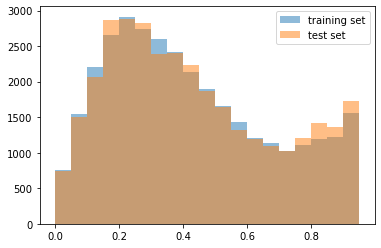

In [12]:
plt.hist(nn_tanimoto_top20_old_and_unique_found_matches_s2v['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'training set')
plt.hist(nn_tanimoto_top20_new_and_unique2_found_matches_s2v['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'test set')
plt.legend()
plt.show()

In [13]:
#nn function
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

def train_nn(X_train, y_train, X_test, y_test, layers = [12, 12, 12, 12, 12, 1],
             model_loss = 'binary_crossentropy', activations = 'relu',
             last_activation = 'sigmoid', model_epochs = 20, model_batch_size = 16,
             save_name = False):
    '''Train a keras deep NN and test on test data, returns (model, history, accuracy, loss)
    
    X_train: matrix like object like pd.DataFrame, training set
    y_train: list like object like np.array, training labels
    X_test: matrix like object like pd.DataFrame, test set
    y_test: list like object like np.array, test labels
    layers: list of ints, the number of layers is the len of this list while the elements
        are the amount of neurons per layer, default: [12, 12, 12, 12, 12, 1]
    model_loss: str, loss function, default: binary_crossentropy
    activations: str, the activation of the layers except the last one, default: relu
    last_activation: str, activation of last layer, default: sigmoid
    model_epochs: int, number of epochs, default: 20
    model_batch_size: int, batch size for updating the model, default: 16
    save_name: str, location for saving model, optional, default: False
    
    Returns:
    model: keras sequential
    history: dict, training statistics
    accuracy: float, accuracy on test set
    loss, float, loss on test set
    
    If save_name is not False and save_name exists this function will load existing model
    '''
    if os.path.exists(save_name) and save_name:
        print('\nLoading existing model')
        nn_model = load_model(save_name)
        with open(save_name + '_train_hist.pickle', 'rb') as hist_inf:
            history = pickle.load(hist_inf)
    else:
        # define the keras model
        nn_model = Sequential()
        #add first layer
        nn_model.add(Dense(layers[0], input_dim = X_train.shape[1], activation = activations))
        #add other layers
        for i in range(1,len(layers)-1): #skip first and last one
            nn_model.add(Dense(layers[i], activation = activations))
        #add last layer
        nn_model.add(Dense(layers[-1], activation = last_activation))
        # compile the keras model
        nn_model.compile(loss = model_loss, optimizer='adam', metrics=['accuracy'])
        # fit the keras model on the dataset
        hist = nn_model.fit(X_train, y_train, epochs = model_epochs, batch_size = model_batch_size)
        history = hist.history
    
    #training set
    print('Training loss: {:.4f}\n'.format(history['loss'][-1]))
    
    #test set    
    loss, accuracy = nn_model.evaluate(X_test, y_test)
    print('Test accuracy: {:.2f}'.format(accuracy*100))
    print('Test loss: {:.4f}'.format(loss))
    
    if save_name and not os.path.exists(save_name):
        print('Saving model at:', save_name)
        nn_model.save(save_name)
        with open(save_name + '_train_hist.pickle', 'wb') as hist_outf:
            pickle.dump(history, hist_outf)
    
    return nn_model, history, accuracy, loss

In [73]:
test_layers = [10,24,24,24,1]
model_name = os.path.join(path_data, 'nn_2000_queries_top20_1')
X_tanimoto_top20 = nn_tanimoto_top20_old_and_unique_found_matches_s2v.drop('similarity', axis = 1)
y_tanimoto_top20 = nn_tanimoto_top20_old_and_unique_found_matches_s2v['similarity']
X_tanimoto_top20_test = nn_tanimoto_top20_new_and_unique2_found_matches_s2v.drop('similarity', axis = 1)
y_tanimoto_top20_test = nn_tanimoto_top20_new_and_unique2_found_matches_s2v['similarity']

nn_2000_queries_top20_1 = train_nn(X_tanimoto_top20, y_tanimoto_top20, X_tanimoto_top20_test, y_tanimoto_top20_test, layers = test_layers,
         model_loss = 'mean_squared_error', activations = 'relu', last_activation = None,
         model_epochs = 50, model_batch_size = 16, save_name = model_name)


Loading existing model
Training loss: 0.0499

40000/40000 [==============================] - 2s 41us/sample - loss: 0.0532 - accuracy: 0.1108
Test accuracy: 11.08
Test loss: 0.0532


In [15]:
nn_2000_queries_top20_1_predict = nn_2000_queries_top20_1[0].predict(X_tanimoto_top20_test)

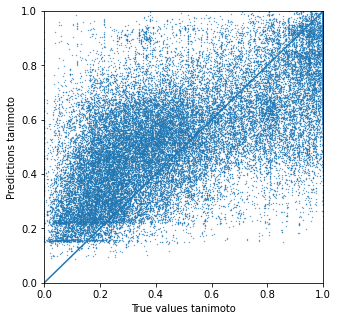

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(y_tanimoto_top20_test, nn_2000_queries_top20_1_predict.flatten(), s = 0.1)
lims = [0,1]
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(lims, lims)
plt.xlabel('True values tanimoto')
plt.ylabel('Predictions tanimoto')
plt.show()

In [17]:
df = pd.DataFrame({'Actual':y_tanimoto_top20_test,'Predicted':nn_2000_queries_top20_1_predict.flatten()})

tanimoto_thres = 0.6
pred_thres = 0.95
print('Predictions:','\n0->0','1->1')
zero_to_zero = np.sum((df.Actual < tanimoto_thres) & (df.Predicted < pred_thres))
one_to_one = np.sum((df.Actual >= tanimoto_thres) & (df.Predicted >= pred_thres))
print(zero_to_zero, one_to_one)
print('0->1','1->0')
print(np.sum((df.Actual < tanimoto_thres) & (df.Predicted >= pred_thres)), 
np.sum((df.Actual >= tanimoto_thres) & (df.Predicted < pred_thres)))

Predictions: 
0->0 1->1
24644 1813
0->1 1->0
75 13468


In [18]:
#plot precision vs recall with different pred_thresholds
precisions = []
recalls = []
pred_thresholds = np.arange(0, 1, 0.05)
for t in pred_thresholds:
    true_pos = np.sum((df.Actual >= tanimoto_thres) & (df.Predicted >= t))
    true_neg = np.sum((df.Actual < tanimoto_thres) & (df.Predicted < t))
    false_pos = np.sum((df.Actual < tanimoto_thres) & (df.Predicted >= t))
    false_neg = np.sum((df.Actual >= tanimoto_thres) & (df.Predicted < t))
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    precisions.append(precision)
    recalls.append(recall)
#precisions, recalls

Text(0.5, 1.0, 'Precision vs Recall of different NN tanimoto prediction cutoffs\nover whole test set')

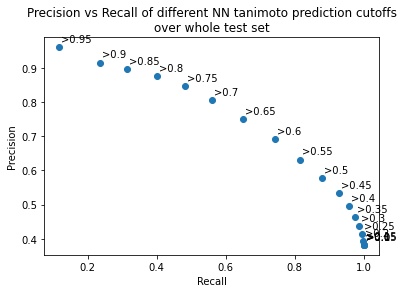

In [19]:
plt.scatter(recalls, precisions)
#add text label for each point
for i, threshold in enumerate(pred_thresholds):
    plt.annotate(">{:.2}".format(threshold),
                (recalls[i], precisions[i]),
                textcoords="offset points", xytext=(2, 5))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall of different NN tanimoto prediction cutoffs\nover whole test set")

In [20]:
nn_prep_new_and_unique2_found_matches_s2v[0]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim
1720,0.0,0.0,0.013468,0.07,0.077736,0,0.118721,0.061886,0.859405
2702,0.0,0.0,0.000000,0.00,0.096940,0,0.135556,0.061887,0.856152
3345,0.0,0.0,0.000000,0.00,-0.016715,0,0.095876,0.061884,0.864985
3602,0.0,0.0,0.000000,0.00,0.000847,0,0.135556,0.061887,0.857681
3992,0.0,0.0,0.000000,0.00,-0.000847,0,0.302395,0.061887,0.856534
...,...,...,...,...,...,...,...,...,...
80489,0.0,0.0,0.000000,0.00,-0.034227,0,0.137269,0.061886,0.857873
80490,0.0,0.0,0.000000,0.00,-0.029796,0,0.137269,0.061886,0.857873
88628,0.0,0.0,0.000295,0.07,0.011142,0,0.190067,0.061877,0.883320
88629,0.0,0.0,0.000000,0.00,-0.013956,0,0.190067,0.061877,0.883320


In [21]:
nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v = []
dif_thres = 0.1
for ID in range(len(nn_prep_new_and_unique2_found_matches_s2v)):
    current_match = nn_prep_new_and_unique2_found_matches_s2v[ID].copy()
    #simlabs = [1 if sim >= sim_cutoff else 0 for sim in current_match['similarity']]
    predict_on = current_match.drop(['label', 'similarity'], axis = 1)
    predictions = nn_2000_queries_top20_1[0].predict(predict_on)
    current_match['sim_predictions'] = predictions
    correct_guess = [abs(pred - lab) <= dif_thres for pred, lab in zip(predictions, current_match['similarity'])]
    current_match['guess_within_thresh'] = correct_guess
    nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v.append(current_match)

In [22]:
nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[1501].sort_values('s2v_score', ascending = False).iloc[:20]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim,sim_predictions,guess_within_thresh
13758,0.334231,0.988047,0.373390,0.991059,0.683692,0,0.501935,0.024084,3.011543e-03,0.635005,[False]
9706,0.164189,0.990386,0.164189,0.990386,0.643439,0,0.683938,0.022146,1.000000e+00,0.653872,[True]
14471,0.162855,0.977033,0.163301,0.982819,0.611327,0,0.683938,0.022146,9.997769e-01,0.628954,[True]
14621,0.356688,0.981526,0.526632,0.994997,0.590493,0,0.267241,0.022446,4.066856e-01,0.670151,[False]
10257,0.352112,0.981526,0.518518,0.994620,0.580845,0,0.267241,0.022446,4.067764e-01,0.665024,[False]
12528,0.255725,0.989662,0.269895,0.993312,0.580519,0,0.580645,0.025276,8.488097e-05,0.586691,[True]
9298,0.441344,0.991059,0.445966,0.991685,0.564761,0,0.866667,0.033031,7.006761e-15,0.601900,[False]
13608,0.125682,0.955867,0.271439,0.991685,0.554345,0,0.578246,0.025873,1.422161e-05,0.557874,[True]
10401,0.194625,0.971446,0.384943,0.991059,0.546287,0,0.470857,0.022296,6.377191e-01,0.649271,[False]
71664,0.349003,0.994620,0.349460,0.994997,0.543248,0,0.746612,0.027065,4.008391e-07,0.563224,[False]


## Optimising NN for tanimoto prediction?

In [26]:
testing_layers = [[10,1],
                  [10,24,1],
                  [10,24,10,1],
                  [10,24,48,10,1],
                  [10,24,48,24,10,1],
                  [10,24,24,24,10,1],
                  [10,24,24,24,24,10,1],
                  [10,24,24,24,24,24,10,1],
                  [10,24,24,48,24,24,10,1],
                  [10,48,1],
                  [10,24,48,1],
                  [10,24,48,1],
                  [24,48,1],
                  [48,48,1],
                  [10,96,1]]
base_model_name = os.path.join(path_data, 'nn_2000_queries_top20_layers_opt')
models_testing_layers = []

for i, test_layers in enumerate(testing_layers):
    model_name_x = base_model_name + '_' + str(i)
    nn_2000_queries_top20_x = train_nn(X_tanimoto_top20, y_tanimoto_top20, X_tanimoto_top20_test,
                                       y_tanimoto_top20_test, layers = test_layers,
                                       model_loss = 'mean_squared_error', activations = 'relu', last_activation = None,
                                       model_epochs = 50, model_batch_size = 16, save_name = model_name_x)
    models_testing_layers.append(nn_2000_queries_top20_x)


Loading existing model
Training loss: 0.0532

40000/40000 [==============================] - 1s 37us/sample - loss: 0.0531 - accuracy: 0.1101
Test accuracy: 11.01
Test loss: 0.0531

Loading existing model
Training loss: 0.0493

40000/40000 [==============================] - 2s 41us/sample - loss: 0.0497 - accuracy: 0.1103
Test accuracy: 11.03
Test loss: 0.0497

Loading existing model
Training loss: 0.0490

40000/40000 [==============================] - 2s 46us/sample - loss: 0.0518 - accuracy: 0.1110
Test accuracy: 11.10
Test loss: 0.0518

Loading existing model
Training loss: 0.0472

40000/40000 [==============================] - 2s 50us/sample - loss: 0.0515 - accuracy: 0.1059
Test accuracy: 10.59
Test loss: 0.0515

Loading existing model
Training loss: 0.0486

40000/40000 [==============================] - 2s 48us/sample - loss: 0.0519 - accuracy: 0.1085
Test accuracy: 10.85
Test loss: 0.0519

Loading existing model
Training loss: 0.0476

40000/40000 [==============================

In [27]:
for i, mdl in enumerate(models_testing_layers):
    print('Model {}\tTraining loss {}\tTesting loss {}'.format(i, mdl[1]['loss'][-1], mdl[-1]))

Model 0	Training loss 0.05318167699612677	Testing loss 0.053072650848701594
Model 1	Training loss 0.049322144233062866	Testing loss 0.04971703301668167
Model 2	Training loss 0.049025724140182136	Testing loss 0.051775668741390106
Model 3	Training loss 0.047193532103300094	Testing loss 0.05149269232302904
Model 4	Training loss 0.04857742875479162	Testing loss 0.05188104930669069
Model 5	Training loss 0.04760398161076009	Testing loss 0.0519426240419969
Model 6	Training loss 0.048593950508534905	Testing loss 0.05152778935842216
Model 7	Training loss 0.04915953196920454	Testing loss 0.05264607293326408
Model 8	Training loss 0.04861697160974145	Testing loss 0.050215591561049225
Model 9	Training loss 0.04881005498915911	Testing loss 0.05050803386457264
Model 10	Training loss 0.04921941782943905	Testing loss 0.050357027768716214
Model 11	Training loss 0.04733268672451377	Testing loss 0.05084937635324895
Model 12	Training loss 0.04693132656030357	Testing loss 0.0489735430881381
Model 13	Trainin

## NN classification for predicting similarity bins
Multiple classes: True hit, high sim >0.8, sim >0.6, no hit <0.6

In [59]:
nn_bins_top20_old_and_unique_found_matches_s2v = make_s2v_selection(nn_prep_old_and_unique_found_matches_s2v, topn = 20)
nn_bins_top20_new_and_unique2_found_matches_s2v = make_s2v_selection(nn_prep_new_and_unique2_found_matches_s2v, topn = 20)

In [98]:
#make one hot encoding of class bins
def make_bins_one_hot(similarities, high_sim=0.8, low_sim=0.6):
    '''Return len(4) list with one-hot encoding of 4 label bins
    
    similarities, list of floats, tanimoto similarities compared to the queries
    high_sim: float, high similarity cutoff, default=0.8
    low_sim: float, similarity cutoff, default=0.6
    
    The 4 bins are: True match, high similarity, similarity, no similarity
    '''
    bins_list = []
    for sim in similarities:
        if sim == 1:
            bins = [1, 0, 0, 0]
        elif sim >= high_sim:
            bins = [0, 1, 0, 0]
        elif sim >= low_sim:
            bins = [0, 0, 1, 0]
        else:
            bins = [0, 0, 0, 1]
        bins_list.append(bins)
    return bins_list

y_bins_top20 = make_bins_one_hot(list(nn_bins_top20_old_and_unique_found_matches_s2v['similarity']))
y_bins_top20_test = make_bins_one_hot(list(nn_bins_top20_new_and_unique2_found_matches_s2v['similarity']))

In [63]:
print(y_bins_top20[:10])
nn_bins_top20_old_and_unique_found_matches_s2v.iloc[:10]

[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1]]


,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim
45105,0.960780,0.195643,0.960780,0.195643,0.911556,1,1.000000,0.037884,1.000000e+00
37297,0.049197,0.070000,0.971344,0.195643,0.887993,0,0.774278,0.038928,4.382372e-02
47164,0.043040,0.135100,0.043040,0.135100,0.878756,0,0.907563,0.038478,1.689367e-01
45071,0.049498,0.070000,0.961919,0.135100,0.867666,0,0.774278,0.034750,8.418306e-05
31857,0.119678,0.070000,0.608107,0.135100,0.844971,0,0.774278,0.038928,4.382372e-02
32268,0.049271,0.070000,0.949622,0.135100,0.839834,0,0.774278,0.034750,8.418306e-05
32756,0.944742,0.135100,0.944742,0.135100,0.823628,1,1.000000,0.037884,1.000000e+00
45081,0.000000,0.000000,0.938445,0.195643,0.779125,0,0.944606,0.036689,2.795346e-02
55372,0.000000,0.000000,0.961388,0.070000,0.777170,0,0.170132,0.047592,2.374814e-13
29909,0.000000,0.000000,0.961388,0.070000,0.774960,0,0.170132,0.041325,3.351044e-05


[4775, 5800, 4484, 24941]


<BarContainer object of 4 artists>

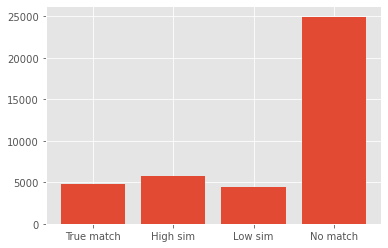

In [100]:
#find label distr
hs = [elem.count(1) for elem in zip(*y_bins_top20)]
print(hs)
xs = ['True match', 'High sim', 'Low sim', 'No match']
plt.bar(xs, hs)

In [74]:
test_layers = [10,24,24,4]
model_name_bins = os.path.join(path_data, 'nn_2000_queries_top20_bins_1')
X_bins_top20 = nn_bins_top20_old_and_unique_found_matches_s2v.drop(['label', 'similarity'], axis = 1)
X_bins_top20_test = nn_bins_top20_new_and_unique2_found_matches_s2v.drop(['label', 'similarity'], axis = 1)

nn_2000_queries_top20_bins = train_nn(X_bins_top20, np.array(y_bins_top20), X_bins_top20_test,
                                   np.array(y_bins_top20_test), layers = test_layers,
                                   model_loss = 'categorical_crossentropy', activations = 'relu',
                                   last_activation = 'sigmoid', model_epochs = 50,
                                   model_batch_size = 16, save_name = model_name_bins)

Train on 40000 samples
Epoch 1/50
40000/40000 [==============================] - 6s 141us/sample - loss: 0.9358 - accuracy: 0.6217
Epoch 2/50
40000/40000 [==============================] - 5s 119us/sample - loss: 0.8324 - accuracy: 0.6731
Epoch 3/50
40000/40000 [==============================] - 5s 117us/sample - loss: 0.8090 - accuracy: 0.6870
Epoch 4/50
40000/40000 [==============================] - 5s 119us/sample - loss: 0.8005 - accuracy: 0.6906
Epoch 5/50
40000/40000 [==============================] - 5s 119us/sample - loss: 0.7934 - accuracy: 0.6904
Epoch 6/50
40000/40000 [==============================] - 5s 119us/sample - loss: 0.7881 - accuracy: 0.6909
Epoch 7/50
40000/40000 [==============================] - 5s 119us/sample - loss: 0.7848 - accuracy: 0.6915
Epoch 8/50
40000/40000 [==============================] - 5s 120us/sample - loss: 0.7809 - accuracy: 0.6920
Epoch 9/50
40000/40000 [==============================] - 5s 120us/sample - loss: 0.7796 - accuracy: 0.6924
Epoch

In [109]:
nn_tested_bins_top20_new_and_unique2_found_matches_s2v = []
for ID in range(len(nn_prep_new_and_unique2_found_matches_s2v)):
    current_match = nn_prep_new_and_unique2_found_matches_s2v[ID].copy()
    #simlabs = [1 if sim >= sim_cutoff else 0 for sim in current_match['similarity']]
    predict_on = current_match.drop(['label', 'similarity'], axis = 1)
    predictions_classes = nn_2000_queries_top20_bins[0].predict_classes(predict_on)
    predictions = nn_2000_queries_top20_bins[0].predict(predict_on)
    current_match['class_predictions'] = predictions_classes
    current_match['predictions'] = [tuple(round(elem,2) for elem in pred) for pred in predictions]
#     correct_guess = [abs(pred - lab) <= dif_thres for pred, lab in zip(predictions, current_match['similarity'])]
#     current_match['guess_within_thresh'] = correct_guess
    nn_tested_bins_top20_new_and_unique2_found_matches_s2v.append(current_match)

In [108]:
[tuple(round(elem,2) for elem in pred) for pred in predictions]

[(0.01, 0.0, 0.0, 0.08),
 (0.0, 0.0, 0.0, 0.05),
 (0.0, 0.0, 0.01, 0.09),
 (0.0, 0.0, 0.01, 0.37),
 (0.0, 0.0, 0.01, 0.07),
 (0.0, 0.0, 0.0, 0.04),
 (0.0, 0.0, 0.01, 0.22),
 (0.0, 0.0, 0.0, 0.07),
 (0.0, 0.01, 0.07, 0.46),
 (0.0, 0.0, 0.0, 0.06),
 (0.0, 0.0, 0.01, 0.34),
 (0.0, 0.0, 0.0, 0.03),
 (0.0, 0.0, 0.0, 0.18),
 (0.0, 0.0, 0.0, 0.18),
 (0.0, 0.0, 0.01, 0.01),
 (0.0, 0.0, 0.0, 0.04),
 (0.01, 0.0, 0.0, 0.05),
 (0.0, 0.0, 0.0, 0.04),
 (0.0, 0.0, 0.01, 0.35),
 (0.01, 0.0, 0.01, 0.17),
 (0.01, 0.02, 0.15, 0.87),
 (0.0, 0.0, 0.0, 0.26),
 (0.03, 0.05, 0.16, 0.81),
 (0.01, 0.0, 0.0, 0.08),
 (0.0, 0.0, 0.01, 0.46),
 (0.0, 0.0, 0.0, 0.23),
 (0.0, 0.05, 0.22, 0.28),
 (0.0, 0.03, 0.14, 0.26),
 (0.0, 0.02, 0.14, 0.49),
 (0.01, 0.0, 0.01, 0.16),
 (0.01, 0.0, 0.0, 0.06),
 (0.0, 0.0, 0.0, 0.09),
 (0.0, 0.0, 0.0, 0.32),
 (0.01, 0.0, 0.0, 0.14),
 (0.06, 0.02, 0.03, 0.06),
 (0.0, 0.04, 0.18, 0.32),
 (0.0, 0.0, 0.0, 0.25),
 (0.01, 0.0, 0.01, 0.13),
 (0.02, 0.03, 0.18, 0.87),
 (0.05, 0.05, 0.24, 0.7

In [87]:
nn_2000_queries_top20_bins[0].predict_classes(predict_on.sort_values(by=['s2v_score'], ascending=False))

array([2, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3], dtype=int64)

In [111]:
nn_tested_bins_top20_new_and_unique2_found_matches_s2v[1].sort_values(by=['s2v_score'], ascending = False).iloc[:10]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim,class_predictions,predictions
66196,0.997898,0.637956,0.997898,0.637956,0.839695,1,1.000000,0.041980,1.000000e+00,0,"(0.05, 0.03, 0.03, 0.0)"
65988,0.442213,0.581404,0.442213,0.581404,0.620984,1,1.000000,0.041980,1.000000e+00,0,"(0.15, 0.06, 0.02, 0.01)"
67788,0.973057,0.581404,0.973057,0.581404,0.598642,1,1.000000,0.041980,1.000000e+00,2,"(0.04, 0.04, 0.06, 0.01)"
66043,0.973057,0.581404,0.973057,0.581404,0.598642,1,1.000000,0.041980,1.000000e+00,2,"(0.04, 0.04, 0.06, 0.01)"
7167,0.545044,0.304312,0.545044,0.304312,0.495941,0,0.411520,0.028856,8.600711e-18,3,"(0.01, 0.02, 0.08, 0.84)"
17281,0.888163,0.195643,0.888163,0.195643,0.416025,0,0.423473,0.044594,3.987625e-04,3,"(0.01, 0.04, 0.09, 0.86)"
66339,0.777920,0.479589,0.777920,0.479589,0.382843,1,1.000000,0.041980,1.000000e+00,0,"(0.07, 0.05, 0.04, 0.03)"
88004,0.245620,0.195643,0.245620,0.195643,0.358107,0,0.090494,0.012750,9.790996e-39,3,"(0.0, 0.0, 0.01, 0.91)"
87824,0.225801,0.304312,0.225801,0.304312,0.354349,0,0.067490,0.012745,9.622057e-39,3,"(0.0, 0.0, 0.02, 0.92)"
87573,0.240569,0.195643,0.240569,0.195643,0.340198,0,0.202258,0.012606,6.346448e-39,3,"(0.0, 0.0, 0.01, 0.92)"


### Oversample to get equal label distribution

In [158]:
#oversample labels to get equal ratio, while labels are in one hot encoding
def oversample_one_hot(matches, labels):
    '''Oversamples the underrepresented labels so that all labels are equal

    matches: pandas DataFrame, concatenation of all queries matching to a library
    labels: list of lists of int, one-hot encoding of labels
    
    Labels are a list of 0s and 1s. Underrepresented labels are multiplied to
    get to the same number as the label with highest prevalence
    '''
#     matches = matches_ori.copy()
    label_counts = [elem.count(1) for elem in zip(*labels)]
    max_count = max(label_counts)
    max_i = np.argmax(label_counts)
    #get the reference values
    ref_ind = [j for j, elem in enumerate(labels) if elem[max_i]==1]
    ref = matches.copy().iloc[ref_ind]
    len_ref = ref.shape[0]
    
    #add label as list of tuples to ref so sample will work later
    ref_label = labels[ref_ind[0]]
    ref['lab'] = [tuple(ref_label)] * len_ref
    #initialise matches_oversampled with ref
    matches_oversampled = ref.copy()
    #oversample each non ref label
    for i, count in enumerate(label_counts):
        if not i == max_i: #skip ref
            current_ind = [j for j, elem in enumerate(labels) if elem[i]==1]
            current = matches.copy().iloc[current_ind]
            len_current = current.shape[0]
            current_label = labels[current_ind[0]]
            current['lab'] = [tuple(current_label)] * len_current
            #find how many times oversampling is needed
            ratio = len_ref / len_current
            #choose a fraction of the data to correct for the decimals
            decimals = ratio % 1
            np.random.seed(42)
            chosen_indices = np.random.choice(range(len_current), round(decimals*len_current))
            balanced_current = current.iloc[chosen_indices]
            #add current data int(ratio) many times
            for k in range(1, int(ratio)+1):
                balanced_current = balanced_current.append(current)
            #add to complete oversampled dataset
            matches_oversampled = matches_oversampled.append(balanced_current)
    #shuffle data to mix labels
    np.random.seed(42)
    matches_oversampled = matches_oversampled.sample(frac=1)
    labels_oversampled = [list(elem) for elem in matches_oversampled['lab']] #remove label column
    matches_oversampled.drop('lab', axis = 1, inplace = True)
    print('New shape:', matches_oversampled.shape)
    return matches_oversampled, labels_oversampled

In [159]:
X_bins_top20_oversampled, y_bins_top20_oversampled = oversample_one_hot(X_bins_top20, y_bins_top20)

New shape: (99764, 7)


In [160]:
[elem.count(1) for elem in zip(*y_bins_top20_oversampled)]

[24941, 24941, 24941, 24941]

In [161]:
y_bins_top20_oversampled

[[0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 0, 1,

In [162]:
test_layers = [10,24,24,4]
model_name_bins_oversampled = os.path.join(path_data, 'nn_2000_queries_top20_bins_oversampled')
X_bins_top20_oversampled_test, y_bins_top20_oversampled_test = oversample_one_hot(X_bins_top20_test, y_bins_top20_test)

nn_2000_queries_top20_bins_overs = train_nn(X_bins_top20_oversampled, np.array(y_bins_top20_oversampled), X_bins_top20_oversampled_test,
                                   np.array(y_bins_top20_oversampled_test), layers = test_layers,
                                   model_loss = 'categorical_crossentropy', activations = 'relu',
                                   last_activation = 'sigmoid', model_epochs = 50,
                                   model_batch_size = 16, save_name = model_name_bins_oversampled)

New shape: (98876, 7)
Train on 99764 samples
Epoch 1/50
99764/99764 [==============================] - 23s 228us/sample - loss: 1.1148 - accuracy: 0.5084
Epoch 2/50
99764/99764 [==============================] - 18s 185us/sample - loss: 1.0719 - accuracy: 0.5329
Epoch 3/50
99764/99764 [==============================] - 18s 183us/sample - loss: 1.0617 - accuracy: 0.5361
Epoch 4/50
99764/99764 [==============================] - ETA: 0s - loss: 1.0513 - accuracy: 0.53 - 19s 186us/sample - loss: 1.0513 - accuracy: 0.5394
Epoch 5/50
99764/99764 [==============================] - 26s 256us/sample - loss: 1.0443 - accuracy: 0.5434
Epoch 6/50
99764/99764 [==============================] - 20s 199us/sample - loss: 1.0389 - accuracy: 0.5449
Epoch 7/50
99764/99764 [==============================] - 24s 238us/sample - loss: 1.0344 - accuracy: 0.5487
Epoch 8/50
99764/99764 [==============================] - 19s 186us/sample - loss: 1.0289 - accuracy: 0.5516
Epoch 9/50
99764/99764 [=================

In [204]:
nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v = []
for ID in range(len(nn_prep_new_and_unique2_found_matches_s2v)):
    current_match = nn_prep_new_and_unique2_found_matches_s2v[ID].copy()
    #simlabs = [1 if sim >= sim_cutoff else 0 for sim in current_match['similarity']]
    predict_on = current_match.drop(['label', 'similarity'], axis = 1)
    predictions_classes = nn_2000_queries_top20_bins[0].predict_classes(predict_on)
    predictions = nn_2000_queries_top20_bins_overs[0].predict(predict_on)
    current_match['class_predictions'] = predictions_classes
    #add highest predicted probablity (so the class pred probability) as confidence score
    current_match['prediction_prob'] = [round(max(pred),2) for pred in predictions]
    current_match['predictions'] = [tuple(round(elem,2) for elem in pred) for pred in predictions]
    
#     correct_guess = [abs(pred - lab) <= dif_thres for pred, lab in zip(predictions, current_match['similarity'])]
#     current_match['guess_within_thresh'] = correct_guess
    nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v.append(current_match)

In [209]:
nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v[1].sort_values('s2v_score', ascending = False).iloc[:10]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim,class_predictions,prediction_prob,predictions
66196,0.997898,0.637956,0.997898,0.637956,0.839695,1,1.000000,0.041980,1.000000e+00,0,0.50,"(0.5, 0.39, 0.06, 0.01)"
65988,0.442213,0.581404,0.442213,0.581404,0.620984,1,1.000000,0.041980,1.000000e+00,0,0.52,"(0.52, 0.15, 0.09, 0.01)"
67788,0.973057,0.581404,0.973057,0.581404,0.598642,1,1.000000,0.041980,1.000000e+00,2,0.25,"(0.12, 0.08, 0.25, 0.01)"
66043,0.973057,0.581404,0.973057,0.581404,0.598642,1,1.000000,0.041980,1.000000e+00,2,0.25,"(0.12, 0.08, 0.25, 0.01)"
7167,0.545044,0.304312,0.545044,0.304312,0.495941,0,0.411520,0.028856,8.600711e-18,3,0.46,"(0.03, 0.2, 0.2, 0.46)"
17281,0.888163,0.195643,0.888163,0.195643,0.416025,0,0.423473,0.044594,3.987625e-04,3,0.43,"(0.02, 0.18, 0.18, 0.43)"
66339,0.777920,0.479589,0.777920,0.479589,0.382843,1,1.000000,0.041980,1.000000e+00,2,0.37,"(0.06, 0.0, 0.37, 0.02)"
88004,0.245620,0.195643,0.245620,0.195643,0.358107,0,0.090494,0.012750,9.790996e-39,3,0.62,"(0.0, 0.05, 0.1, 0.62)"
87824,0.225801,0.304312,0.225801,0.304312,0.354349,0,0.067490,0.012745,9.622057e-39,3,0.68,"(0.01, 0.06, 0.11, 0.68)"
87573,0.240569,0.195643,0.240569,0.195643,0.340198,0,0.202258,0.012606,6.346448e-39,3,0.64,"(0.01, 0.05, 0.1, 0.64)"


## Making the well known performance plot

In [243]:
#testing if top hit is above 0.6 similarity
#look at top20
test_tan_nn_top20 = []
test_sim_mcos = []
test_sim_s2v = []
ideal_case_top20 = []
test_bins_nn_top20_overs = []

pred_thresh = 0.8
mass_sim_thresh = 0.95
restr_nn = False # do mass+spec2vec restricitons on nn models
highest_pred = False # take highest prediction instead of first prediction over threshold
highest_class = True # take highest predicted class instead of first prediction over threshold
threshold = 0.4
topn = 20 #only look at top 20
sim_threshold = 0.6
mc_matches_thresh = 0.35 # mod cosine matches threshold corresponds to min match 6
bins_exclude = [3] #classes to filter out with bins nn
restr_pred = 0.35 #cutoff for the class prediction probability

for ID in range(len(nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v)):
    # mass + mod cosine
    current_match = nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['mod_cosine_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['mod_cosine_score'] > threshold)
                                  & (current_match['mod_cosine_matches'] > mc_matches_thresh)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['mod_cosine_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_mcos.append(best_bet)

    # Scenario 1: mass + Spec2Vec + threshold
    current_match = nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    #inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    #current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_s2v.append(best_bet)
    
    # Scenario 3: (Spec2Vec + threshold) after filtering for non-similar matches with nn
    if not restr_nn:
        df_select = current_match[(current_match['sim_predictions'] >= pred_thresh)]
    else:
        df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                      & (current_match['sim_predictions'] >= pred_thresh)
                                      & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_pred:
            #look at highest predicted above prediction threshold
            sim = df_select.iloc[np.argmax(df_select['sim_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_tan_nn_top20.append(best_bet)
    
    # ideal case: how many queries have an actual match above s2v threshold and >0.6 tanimoto
    df_select = current_match[(current_match['s2v_score'] > threshold)]
    best_bet = -1
    if df_select.shape[0] > 0:
        if any(df_select['similarity'] > 0.6):
            best_bet = 1
    ideal_case_top20.append(best_bet)
    
    # Scenario 4: (Spec2Vec + threshold) after filtering for non-similar matches with nn for oversampled bins
    current_match = nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    df_select = current_match.query('class_predictions not in @bins_exclude')
    if restr_nn:
        df_select = df_select[(df_select['mass_sim'] >= mass_sim_thresh)
                                      & (df_select['s2v_score'] > threshold)]
    if restr_pred:
        df_select = df_select[(df_select['prediction_prob'] >= restr_pred)]
    
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_class:
            #look at highest predicted: identical match is class 0
            sim = df_select.iloc[np.argmin(df_select['class_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_bins_nn_top20_overs.append(best_bet)
    
test_tan_nn_top20_arr = np.array(test_tan_nn_top20)
test_sim_mcos_arr = np.array(test_sim_mcos)
test_sim_s2v_arr = np.array(test_sim_s2v)
ideal_case_top20_arr = np.array(ideal_case_top20)
test_bins_nn_top20_overs_arr = np.array(test_bins_nn_top20_overs)

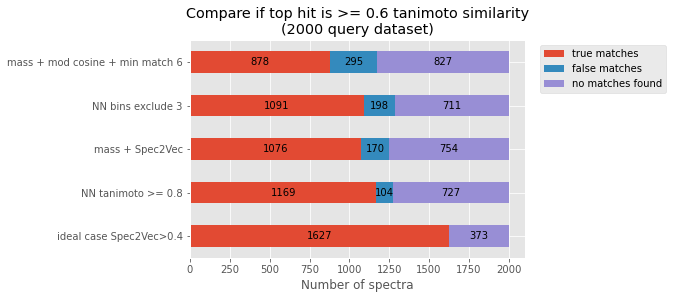

In [244]:
plt.style.use('ggplot')
if restr_nn:
    ylabels = ['mass + mod cosine + min match 6',
               'mass + Spec2Vec',
               'mass + Spec2Vec + NN tanimoto >= {}'.format(pred_thresh),
               'ideal case Spec2Vec>0.4',
               'mass + Spec2Vec + NN bins exclude {}'.format(', '.join(bins_exclude))]
else:
    ylabels = ['mass + mod cosine + min match 6',
               'mass + Spec2Vec',
               'NN tanimoto >= {}'.format(pred_thresh),
               'ideal case Spec2Vec>0.4',
               'NN bins exclude {}'.format(', '.join(map(str,bins_exclude)))]
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_sim_mcos_arr == 1), np.sum(test_sim_mcos_arr == 0), np.sum(test_sim_mcos_arr == -1)],
                 [np.sum(test_sim_s2v_arr == 1), np.sum(test_sim_s2v_arr == 0), np.sum(test_sim_s2v_arr == -1)],
                 [np.sum(test_tan_nn_top20_arr == 1), np.sum(test_tan_nn_top20_arr == 0), np.sum(test_tan_nn_top20_arr == -1)],
                 [np.sum(ideal_case_top20_arr == 1), np.sum(ideal_case_top20_arr == 0), np.sum(ideal_case_top20_arr == -1)],
                 [np.sum(test_bins_nn_top20_overs_arr == 1), np.sum(test_bins_nn_top20_overs_arr == 0), np.sum(test_bins_nn_top20_overs_arr == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

#fig, ax = plt.subplots(figsize=(5, 5))
ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none', figsize=(6, 4))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if width != 0:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(width), 
                horizontalalignment='center', 
                verticalalignment='center')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Compare if top hit is >= {} tanimoto similarity\n(2000 query dataset)'.format(sim_threshold))
#plt.figure(figsize=(5,5))
plt.show()

## PCA?

In [235]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X_bins_top20)
principal_df = pd.DataFrame(data = principal_components,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4'])
pca.explained_variance_ratio_

array([0.48671871, 0.27323627, 0.18129547, 0.03188169])

In [237]:
cat_labs = ['Similar' if score >= 0.6 else 'Non-similar' for score in y_tanimoto_top20]
label_df = pd.DataFrame(cat_labs, columns = ['target'])
final_df = pd.concat([principal_df, label_df], axis = 1)
final_df

,PC1,PC2,PC3,PC4,target
0,0.331354,1.145551,0.518929,-0.030552,Similar
1,-0.444350,0.569380,-0.135958,0.559953,Similar
2,-0.729095,0.109895,0.253081,-0.091388,Similar
3,-0.496756,0.582539,-0.165980,0.539680,Similar
4,-0.583225,0.441300,-0.037412,0.249301,Similar
...,...,...,...,...,...
39995,-0.037546,-0.696762,-0.079942,-0.062997,Non-similar
39996,0.417285,0.001047,-0.411345,-0.051617,Similar
39997,-0.050804,-0.494532,-0.118788,-0.062408,Non-similar
39998,0.015806,-0.623574,-0.119762,-0.033965,Non-similar


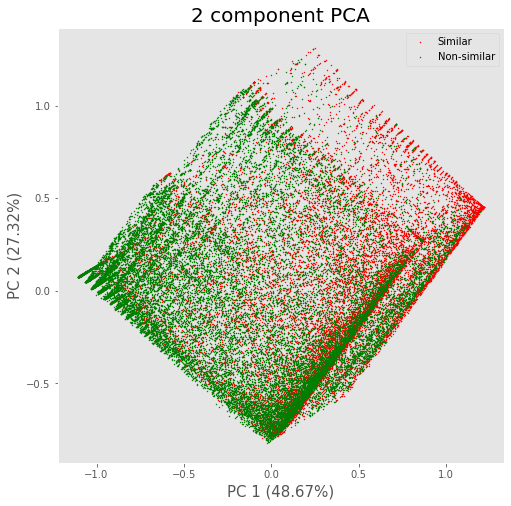

In [241]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100), fontsize = 15)
ax.set_ylabel('PC 2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1]*100), fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Similar', 'Non-similar']
colours = ['r', 'g']
for target, colour in zip(targets,colours):
    indices_to_keep = final_df['target'] == target
    ax.scatter(final_df.loc[indices_to_keep, 'PC1'],
               final_df.loc[indices_to_keep, 'PC2'],
               c = colour, s = 0.9)
ax.legend(targets)
ax.grid()